<a href="https://colab.research.google.com/github/saguileran/MD-SCPI/blob/main/NoteBooks/Plots_MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Github
%%capture

!rm -r /content/MD-SCPI
!git clone https://github.com/saguileran/MD-SCPI

import sys
!{sys.executable} -m pip install ipympl

In [2]:
!ls "MD-SCPI/PDBs/MC/AS4/300K"

MR-AS4_10_MR-AS4.inpcrd_mc.dat.gz   MR-AS4_5_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_10_MR-AS4.inpcrd_MC.mol2.gz  MR-AS4_6_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_1_MR-AS4.inpcrd_mc.dat.gz    MR-AS4_7_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_2_MR-AS4.inpcrd_mc.dat.gz    MR-AS4_8_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_3_MR-AS4.inpcrd_mc.dat.gz    MR-AS4_9_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_4_MR-AS4.inpcrd_mc.dat.gz


In [12]:
import gzip
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from google.colab import output
import numpy as np
import matplotlib as mpl
from scipy.stats import linregress
import matplotlib.cm as cm

def ReadGz(path):
  #data = pd.read_csv(path, compression='gzip',  header=4, delimiter="  ")[['#', 'Step', 'Unnamed: 6', 'Unnamed: 7', ' RMSD']].rename({'#':'Step', 'Step':'Energy', 'Unnamed: 6':'RMSD', 'Unnamed: 7':'DX', ' RMSD':'DY'}, axis=1)
  file1 = gzip.open(path)
  a = file1.read()

  array, c = [], 0
  text = str(a).split()[11:]
  head = text[:14] # 20 

  for i in range(20,len(text)):
    c += 1
    if '\\n' in text[i]:
      text[i] = text[i].replace("\\n","")
      text[i] = text[i].replace("'","")
      words = [float(word) for word in text[i-c+1:i+1]]
      array.append(words) #text[i-c+1:i+1])
      c = 0

  array = np.array(array)
  data = pd.DataFrame({head[i]:array[:,i] for i in range(len(head))})
  return data

%matplotlib ipympl
output.enable_custom_widget_manager()

In [13]:
#file1 = gzip.open('MD-SCPI/PDBs/MC/AS4/300K/MR-AS4_1_MR-AS4.inpcrd_mc.dat.gz')
#ReadGz('MD-SCPI/PDBs/MC/AS4/300K/MR-AS4_1_MR-AS4.inpcrd_mc.dat.gz')['Step']

In [124]:
temperatures = ['300K', '600K', '1200K', '2400K', '4800K', '9600K']
colors = ['gray', 'violet', 'red', 'green', 'orange', 'blue']
unit, unit2 = np.linspace(0.1, 0.9, 10), np.linspace(0.9, 0.2, 10)
Colors = [cm.Greys(unit), cm.Purples(unit), cm.Reds(unit), cm.Greens(unit), cm.Oranges(unit), cm.Blues(unit)]
path = 'MD-SCPI/PDBs/MC/AS4/' #300K/MR-AS4_1_MR-AS4.inpcrd_mc.dat.gz'
gz_files = [f for f in listdir(path+temperatures[0]) if isfile(join(path+temperatures[0], f))]

for i in range(10):
  for j in range(6):
    Colors[j][i][-1]=unit2[i]

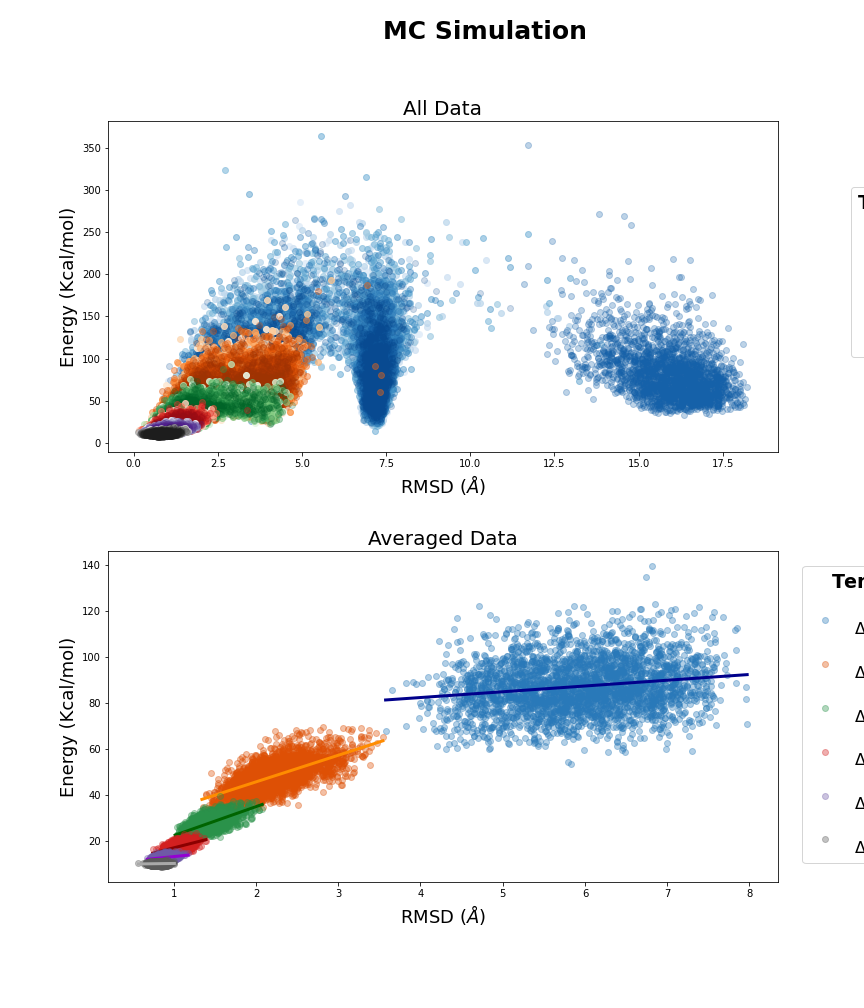

In [131]:
plt.close()
fig, axs = plt.subplots(2,1,figsize=(12,14), gridspec_kw={'hspace': 0.3})

parameters = pd.DataFrame()

c=0
for i in range(len(temperatures)-1,-1,-1): #list(reversed((temperatures))):
  rmsd, energy = [], []
  #for file in gz_files:
  for j in range(len(gz_files)):
    data = ReadGz(path+temperatures[i]+'/'+gz_files[j])
    rmsd.append(data['RMSD']); energy.append(data['Energy'])
    if j==7:   axs[0].plot(data['RMSD'], data['Energy'], 'o', label=temperatures[i], color=Colors[i][j])#colors[i], alpha=1-0.15*i)
    else:      axs[0].plot(data['RMSD'], data['Energy'], 'o',  color=Colors[i][j])
    # rmsd_array = np.linspace(min(data['RMSD']), max(data['RMSD']), 1000)
    # slope, intercept, r_value, p_value, std_err = linregress(data['RMSD'], data['Energy'])
    # axs[0].plot(rmsd_array, slope*rmsd_array+intercept, color='dark'+colors[i], lw=3)

    value = pd.DataFrame({'temperature':temperatures[i],'slope':slope, 'intercept':intercept, 'r_value':r_value, 
                        'p_value':p_value, 'std_err':std_err, #'deltaE':float(max(energy)-min(energy)), 'deltaRMSD':float(max(rmsd)-min(rmsd)),
                        'E_mean':np.mean(energy), 'RMSD_mean':np.mean(rmsd)}, index=[c])
    parameters = pd.concat([parameters, value], ignore_index=True)
    c += 1
  
    # -------- remove repeated legend labels -------------
    # handles, labels = plt.gca().get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # plt.legend(by_label.values(), by_label.keys())
  
  # -------- average ------------------
  rmsd = np.average(np.array(rmsd), axis=0); energy = np.average(np.array(energy), axis=0)
  slope, intercept, r_value, p_value, std_err = linregress(rmsd, energy)
  rmsd_array = np.linspace(min(rmsd), max(rmsd), 1000)
  if len(temperatures[i]) == 4:
           label = '  '+temperatures[i]+',     r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
  else:    label = '  '+temperatures[i]+',   r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
  axs[1].plot(rmsd, energy, 'o', label=label, color=Colors[i][-3])#colors[i], alpha=0.5)
  axs[1].plot(rmsd_array, slope*rmsd_array+intercept, color='dark'+colors[i], lw=3)
  
# ----------- legends, labels and titles for each axis ----------------
axs[0].set_ylabel('Energy (Kcal/mol)', fontsize='18'); axs[0].set_xlabel('RMSD ($\AA$)', fontsize='18'); 
axs[0].legend(title='Temperature', bbox_to_anchor=(1.11, .8), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'}, borderaxespad=0.)
axs[0].set_title('All Data', fontsize='20', fontweight='normal')
#plt.ylim((0, 100)); plt.xlim((0, 10))

#axs[1].sharex(axs[0,0])
axs[1].set_xlabel('RMSD ($\AA$)', fontsize='18'); axs[1].set_ylabel('Energy (Kcal/mol)', fontsize='18')
axs[1].legend(title='Temperature, $r_{value}$', bbox_to_anchor=(1.025, .98), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
axs[1].set_title('Averaged Data', fontsize='20', fontweight='normal')

plt.suptitle('            MC Simulation', fontsize='25', fontweight='bold')
#plt.tight_layout()

fig.savefig("./energies.png", transparent=True, bbox_inches='tight')

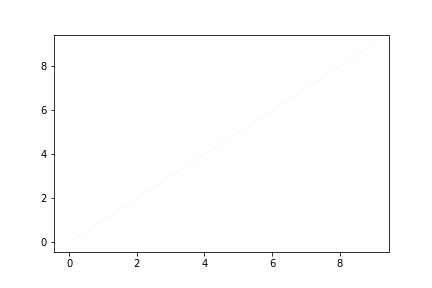

In [36]:
from matplotlib import colormaps
import matplotlib.cm as cm

colors_1 = cm.Blues(np.linspace(0, 1, 10))

plt.close()
plt.figure()
plt.plot(np.arange(10), color=colors_1[0])
plt.show()

#colormaps['Blues'][0]

In [7]:
axs[0]

<AxesSubplot:>

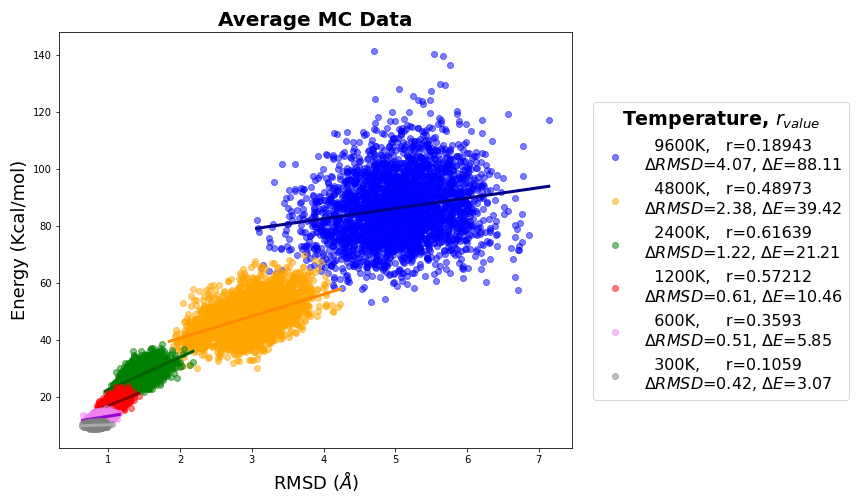

In [ ]:
plt.close()
fig = plt.figure(figsize=(12,7))

parameters = pd.DataFrame()

for i in range(len(temperatures)-1,-1,-1):#list(reversed((temperatures))):
  rmsd, energy = [], []
  for file in gz_files:
    data = ReadGz(path+temperatures[i]+'/'+file)
    rmsd.append(data['RMSD']); energy.append(data['Energy'])
    #plt.plot(data['RMSD'], data['Energy'], 'o', label=temp)
  
  rmsd = np.average(np.array(rmsd), axis=0); energy = np.average(np.array(energy), axis=0)
  slope, intercept, r_value, p_value, std_err = linregress(rmsd, energy)

  value = pd.DataFrame({'temperature':temperatures[i],'slope':slope, 'intercept':intercept, 'r_value':r_value, 
                        'p_value':p_value, 'std_err':std_err, 'deltaE':max(energy)-min(energy), 'deltaRMSD':max(rmsd)-min(rmsd),
                        'E_mean':np.mean(energy), 'RMSD_mean':np.mean(rmsd)}, index=[i])
  parameters = pd.concat([parameters, value], ignore_index=True)

  rmsd_array = np.linspace(min(rmsd), max(rmsd), 1000)
  if len(temperatures[i]) == 4:
           label = '  '+temperatures[i]+',     r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
  else:    label = '  '+temperatures[i]+',   r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
  
  plt.plot(rmsd, energy, 'o', label=label, color=colors[i], alpha=0.5)
  plt.plot(rmsd_array, slope*rmsd_array+intercept, color='dark'+colors[i], lw=3)
  
plt.xlabel('RMSD ($\AA$)', fontsize='18'); plt.ylabel('Energy (Kcal/mol)', fontsize='18')
plt.legend(title='Temperature, $r_{value}$', bbox_to_anchor=(1.025, .85), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
plt.title('Average MC Data', fontsize='20', fontweight='bold')
#plt.ylim((0, 100)); plt.xlim((0, 10))


fig.tight_layout()

In [ ]:
parameters

,temperature,slope,intercept,r_value,p_value,std_err,deltaE,deltaRMSD,E_mean,RMSD_mean
0,9600K,3.618476,68.128719,0.189429,1.237636e-25,0.342554,88.1144,4.0729,86.377283,5.043162
1,4800K,7.686823,25.420495,0.489727,9.033058e-181,0.249937,39.4214,2.3833,48.524411,3.005652
2,2400K,11.422871,11.276015,0.616388,1.728381e-313,0.266517,21.2101,1.2229,27.205981,1.394568
3,1200K,10.020911,7.149810,0.572122,1.938263e-260,0.262365,10.4608,0.6064,17.830673,1.065857
4,600K,3.986522,9.410569,0.359297,4.207386e-92,0.189108,5.8456,0.5102,12.935471,0.884205
5,300K,0.883189,9.500466,0.105896,6.096991e-09,0.151465,3.0744,0.4169,10.224093,0.819335
